# BUT WAIT, THERE'S MORE...

Just before we move on, there's one more pricer I want to show you

## The MOST POWERFUL MODEL that I've ever demoed live

Recap on our best 2 models so far:

- GPT-4.1 with RAG got to **\$50.72**
- Our fine-tuned model got to **\$46.67**

Can we do better??

## You may be familiar with the technique called "Ensembling" - combining different models

It turns out that often you can find ways to combine 2 different models, and the results can outperform either of the models indidually.

The first time you hear it, it can sound counter-intuitive.

But let's see! To keep it simple, we'll just take the average prediction from the 2 models...



In [ ]:
# imports

import os
import re
from dotenv import load_dotenv
from huggingface_hub import login
import pickle
from sentence_transformers import SentenceTransformer
from evaluator import evaluate
from chromadb import PersistentClient
from litellm import completion
from openai import OpenAI


In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')
DB = "products_vectorstore"

In [3]:
# Log in to HuggingFace
# If you don't have a HuggingFace account, you can set one up for free at www.huggingface.co
# And then add the HF_TOKEN to your .env file as explained in the project README

hf_token = os.environ['HF_TOKEN']
login(token=hf_token, add_to_git_credential=False)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
client = PersistentClient(path=DB)
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
collection_name = "products"
collection = client.get_or_create_collection(collection_name)

## With that background, let's populate our Chroma database

### By calculating vectors for 400,000 scraped products

In [ ]:
# OpenAI
openai = OpenAI()

In [8]:
# Load in the test pickle file

with open('../test.pkl', 'rb') as file:
    test = pickle.load(file)

In [9]:
# We need to give some context to OpenAI by selecting 5 products with similar descriptions

def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [10]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [ ]:
def preprocess(item):
    message = f"Reply with a 2-3 sentence summary of this product. This will be used to find similar products so it should be clear, concise, complete. Details:\n{item}"
    messages = [{"role": "user", "content": message}]
    response = completion(model="groq/openai/gpt-oss-20b", messages=messages)
    return response.choices[0].message.content

In [12]:
def vector(item):
    text = preprocess(item.text)
    return model.encode(text)

In [13]:
def find_similars(item):
    vec = vector(item)
    results = collection.query(query_embeddings=vec.astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [14]:
# Utility function that extracts a price from a response from GPT-4.1-mini

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [15]:
# The function for gpt-4.1

def gpt_4_1_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4.1", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=8
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [16]:
import modal
Pricer = modal.Cls.from_name("pricer-service", "Pricer")
pricer = Pricer()

In [17]:
def ensemble(item):
    price1 = gpt_4_1_rag(item)
    description = item.test_prompt().replace("How much does this cost to the nearest dollar?\n\n","").replace("\n\nPrice is $","")
    price2 = pricer.price.remote(description)
    return (price1 + price2) / 2

1: Guess: $330.49 Truth: $374.41 Error: $43.92 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $208.50 Truth: $225.11 Error: $16.61 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $38.98 Truth: $61.68 Error: $22.70 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $394.50 Truth: $599.99 Error: $205.49 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $17.50 Truth: $16.99 Error: $0.51 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $16.50 Truth: $31.99 Error: $15.49 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $101.00 Truth: $101.79 Error: $0.80 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $274.00 Truth: $289.00 Error: $15.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $640.00 Truth: $635.86 Error: $4.13 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $57.00 Truth: $65.99 Error: $8.99 Item: HOLDWILL 6 Pack LED Shop Light, 4FT 24W ...
11: Guess: $229.50 Truth: $254.21 Error: $24.72 Item: V

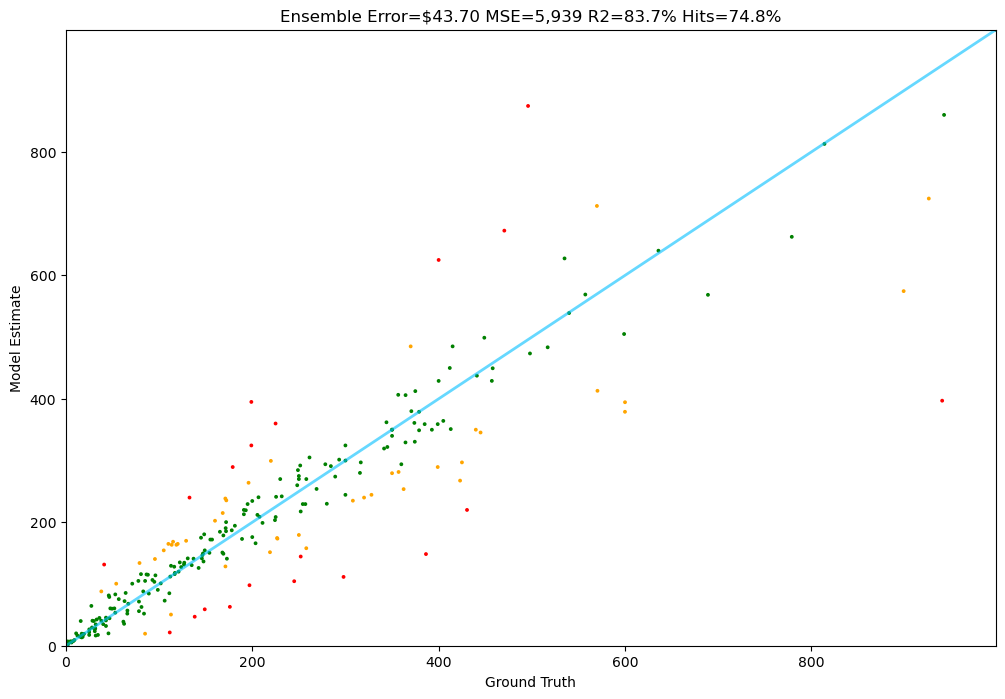

In [ ]:
evaluate(ensemble, test)

# AMAZING!

I hope you enjoyed this result.

But here's the thing: you can do better!

Other students have got this into the lower 30s..

- Experiment with more models
- Use different encoders
- Use an LLM to pre-process descriptions
- Use the Deep Neural network
- Make a new Ensemble of all these models

You should be able to get there too!